Using TensorFlow backend.


Read  1883


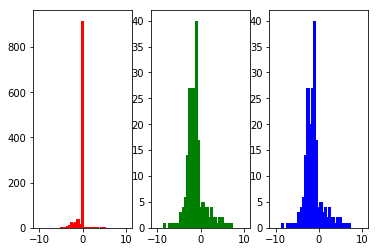

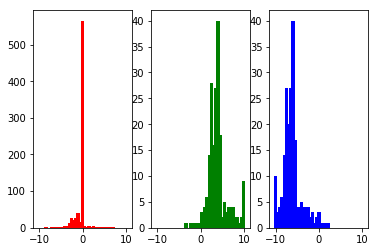

Read  1531  samples
train_samples      =  1224
validation_samples =  307
Resize sample size to avoid Keras warning
train_samples      =  1216
validation_samples =  288
samples_per_epoch 1216


In [1]:
import utils
import numpy as np

path = 'data/'
train_generator, validation_generator, train_size, valid_size = \
    utils.generate_train_data2(path)